# Linear Regression Tutorial with Python and sklearn

In this tutorial, we'll walk through the process of performing linear regression using Python, pandas, matplotlib, and sklearn. We'll use real-world data from the USGS (United States Geological Survey) and Daymet to predict streamflow based on temperature.

## 1. Setting Up the Environment

First, let's import the necessary libraries and set up some functions:


In [8]:
from sklearn.linear_model import LinearRegression


In [ ]:
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression

def create_usgs_url(site_no, begin_date, end_date):
    return (
        f'https://waterdata.usgs.gov/nwis/dv?'
        f'cb_00060=on&format=rdb&referred_module=sw&'
        f'site_no={site_no}&'
        f'begin_date={begin_date}&'
        f'end_date={end_date}'
    )

def open_usgs_data(site, begin_date, end_date):
    url = create_usgs_url((site), begin_date, end_date)
    response = urllib.request.urlopen(url)
    df = pd.read_table(
        response,
        comment='#',
        skipfooter=1,
        sep='\s+',
        names=['agency', 'site', 'date', 'streamflow', 'quality_flag'],
        index_col=2,
        engine='python'
    ).iloc[2:]

    # Now convert the streamflow data to floats and
    # the index to datetimes. When processing raw data
    # it's common to have to do some extra postprocessing
    df['streamflow'] = df['streamflow'].astype(np.float64)
    df.index = pd.DatetimeIndex(df.index)
    return df

def open_daymet_data(lat, lon, begin_date, end_date):
    args = {'lat':  lat, 'lon': lon, 'format': 'csv',
            'start': begin_date, 'end': end_date}
    query = urllib.parse.urlencode(args)
    url = f"https://daymet.ornl.gov/single-pixel/api/data?{query}"
    response = urllib.request.urlopen(url)
    df = pd.read_csv(response, header=6)
    datestring = (df['year'].astype(str) + df['yday'].astype(str))
    dates = pd.to_datetime(datestring, format='%Y%j')
    df.index = pd.DatetimeIndex(dates)
    return df


## 2. Data Collection and Preparation

We'll use two helper functions `open_usgs_data()` and `open_daymet_data()` to fetch our data. These functions are already defined in the script.

Let's fetch and prepare our data:

In [ ]:
site = '09506000'
begin_date = '2000-09-25'
end_date = '2022-09-25'
lat = 34.4483605
lon = -111.7898705

daymet_df = open_daymet_data(lat, lon, begin_date, end_date)
verde_df = open_usgs_data(site, begin_date, end_date)
daymet_df = daymet_df.reindex(verde_df.index)
daymet_df['streamflow'] = verde_df['streamflow']
df = daymet_df

# Resample to monthly data
df_monthly = df.resample('M').mean()
df_monthly = df_monthly.dropna()

/tmp/ipykernel_44383/3379894440.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()



## 3. Exploratory Data Analysis

Let's create a scatter plot to visualize the relationship between maximum temperature and streamflow:

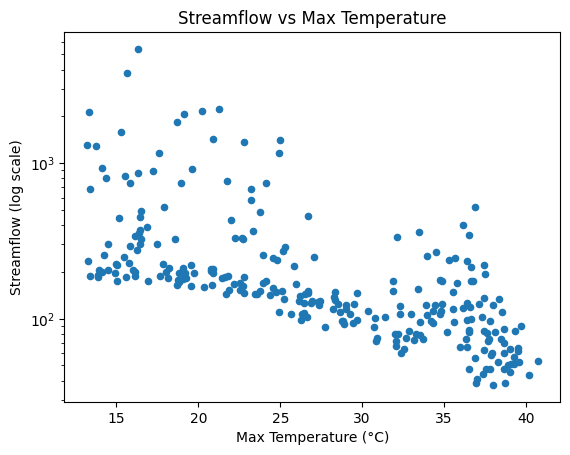

In [6]:
df_monthly.plot.scatter(x='tmax (deg c)', y='streamflow')
plt.semilogy()
plt.title('Streamflow vs Max Temperature')
plt.xlabel('Max Temperature (°C)')
plt.ylabel('Streamflow (log scale)')
plt.show()

This plot shows the relationship between maximum temperature and streamflow. Note that we're using a logarithmic scale for the y-axis (streamflow) to better visualize the data distribution.

## 4. Linear Regression

Now, let's perform linear regression using sklearn:


/workspaces/hwrs564a_course_materials_rlsandovalp/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


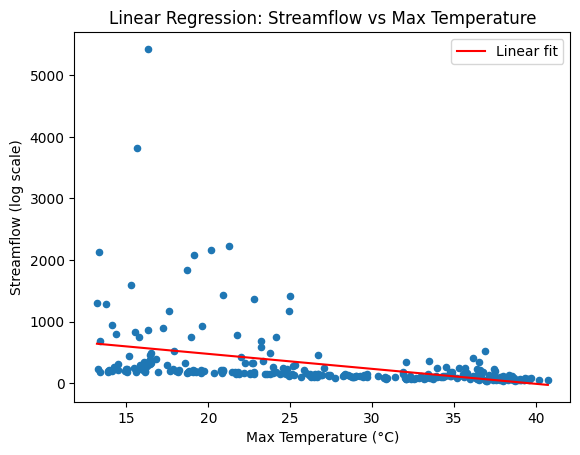

In [9]:
lm = LinearRegression()
X = df_monthly[['tmax (deg c)']]
y = df_monthly[['streamflow']]
lm.fit(X, y)

# Generate points for the fit line
X_fit = np.linspace(X.min(), X.max(), 20).reshape(-1, 1)
y_fit = lm.predict(X_fit)

# Plot the data and the fit line
df_monthly.plot.scatter(x='tmax (deg c)', y='streamflow')
plt.plot(X_fit, y_fit, color='red', label='Linear fit')
plt.title('Linear Regression: Streamflow vs Max Temperature')
plt.xlabel('Max Temperature (°C)')
plt.ylabel('Streamflow (log scale)')
plt.legend()
plt.show()


This plot shows our data points and the linear regression line. However, you might notice that the fit doesn't look great, especially for lower temperatures.

## 5. Log-transformed Linear Regression

To improve our fit, let's try a log-transformed linear regression:


/workspaces/hwrs564a_course_materials_rlsandovalp/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/workspaces/hwrs564a_course_materials_rlsandovalp/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


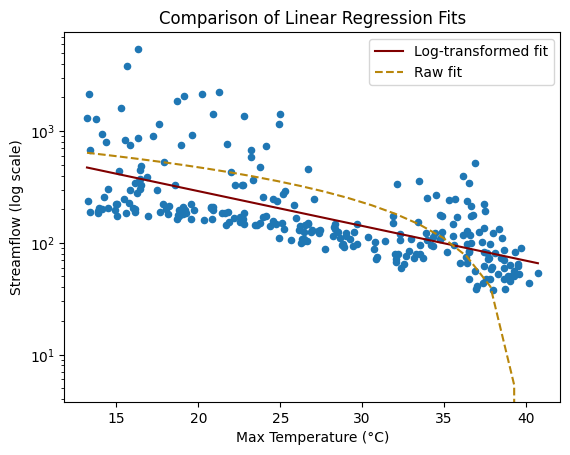

In [10]:
log_lm = LinearRegression()
X = df_monthly[['tmax (deg c)']]
# Take the log of the streamflow data
y_log = np.log(df_monthly[['streamflow']])
log_lm.fit(X, y_log)

# Generate points for both fit lines
X_fit = np.linspace(X.min(), X.max(), 20).reshape(-1, 1)
y_fit_log = np.exp(log_lm.predict(X_fit))
y_fit = lm.predict(X_fit)

# Plot the data and both fit lines
df_monthly.plot.scatter(x='tmax (deg c)', y='streamflow')
plt.plot(X_fit, y_fit_log, color='maroon', label='Log-transformed fit')
plt.plot(X_fit, y_fit, color='darkgoldenrod', linestyle='--', label='Raw fit')
plt.semilogy()
plt.title('Comparison of Linear Regression Fits')
plt.xlabel('Max Temperature (°C)')
plt.ylabel('Streamflow (log scale)')
plt.legend()
plt.show()


This plot compares the original linear regression (dashed line) with the log-transformed linear regression (solid line). The log-transformed fit appears to better capture the relationship in the data.

## 6. Model Evaluation

Let's compare the performance of our models:


In [11]:

log_score = log_lm.score(X, y_log)
reg_score = lm.score(X, y)

print(f"R-squared score for log-transformed model: {log_score:.4f}")
print(f"R-squared score for raw model: {reg_score:.4f}")


R-squared score for log-transformed model: 0.4453
R-squared score for raw model: 0.1458



The R-squared score tells us how well our model fits the data, with 1 being a perfect fit. The log-transformed model typically performs better in this case.

## 7. Interpreting the Model

Finally, let's look at the coefficients of our log-transformed model:


In [12]:
coefficient = log_lm.coef_[0][0]
intercept = log_lm.intercept_[0]

print(f"Coefficient: {coefficient:.4f}")
print(f"Intercept: {intercept:.4f}")

Coefficient: -0.0716
Intercept: 7.1025


These values define our regression line in the form:

$$
log(streamflow) = m \cdot temperature + b
$$

This means that for every 1°C increase in maximum temperature, we expect the log of streamflow to change by the coefficient value.




## Extra content: Time Series Forecasting: Predicting Streamflow

Now, let's develop a regression analysis that uses the previous 7 days of streamflow to predict the next day's streamflow. This type of analysis is useful for short-term forecasting and is an example of autoregression.

### 8.1 Preparing the Data

First, we need to prepare our data by creating lagged features:


In [13]:
# Ensure our data is sorted by date
df = df.sort_index()

# Create lagged features
for i in range(1, 8):
    df[f'streamflow_lag_{i}'] = df['streamflow'].shift(i)

# Drop rows with NaN values (first 7 days where we don't have full lag data)
df_lagged = df.dropna()

# Split into features (X) and target (y)
X = df_lagged[['streamflow_lag_1', 'streamflow_lag_2', 'streamflow_lag_3', 
               'streamflow_lag_4', 'streamflow_lag_5', 'streamflow_lag_6', 
               'streamflow_lag_7']]
y = df_lagged['streamflow']


### 8.2 Training the Model

Now, let's train our linear regression model:


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

### 8.3 Evaluating the Model

Let's evaluate our model's performance:

In [15]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Mean Squared Error: 662916.57
R-squared Score: 0.52


### 8.4 Visualizing the Results

We can visualize how well our predictions match the actual values:

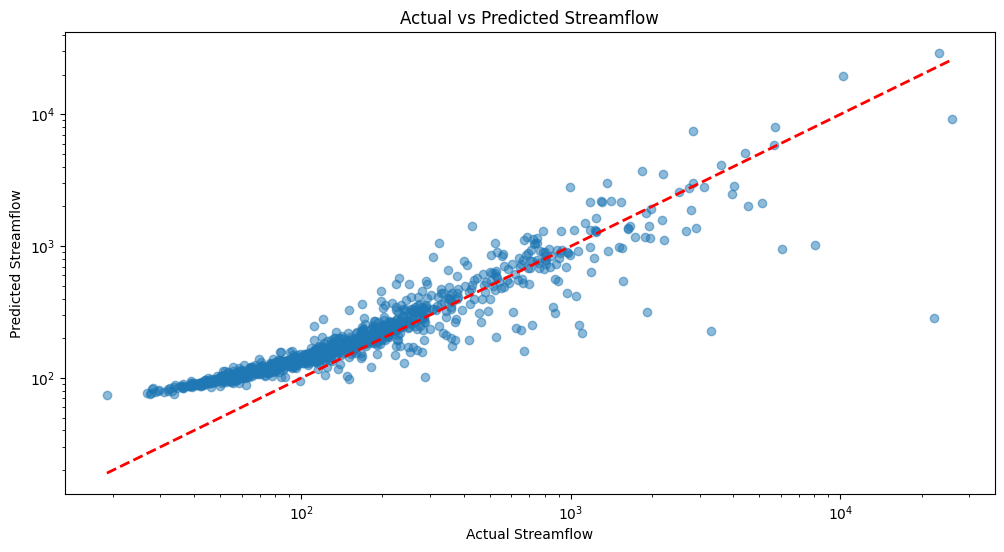

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
plt.title("Actual vs Predicted Streamflow")
plt.loglog()
plt.show()

This plot shows how well our predictions (y-axis) match the actual values (x-axis). Points closer to the red dashed line indicate better predictions.

### 8.5 Interpreting the Model

We can examine the coefficients to understand the impact of each day's previous streamflow on the prediction:

In [17]:
for i, coef in enumerate(model.coef_, 1):
    print(f"Coefficient for {i} day(s) ago: {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

Coefficient for 1 day(s) ago: 0.8167
Coefficient for 2 day(s) ago: -0.2255
Coefficient for 3 day(s) ago: 0.0734
Coefficient for 4 day(s) ago: -0.0025
Coefficient for 5 day(s) ago: 0.0547
Coefficient for 6 day(s) ago: 0.0134
Coefficient for 7 day(s) ago: 0.0941
Intercept: 54.8904


These coefficients show the weight given to each day's streamflow in predicting the next day's streamflow. A positive coefficient indicates that an increase in streamflow on that day is associated with an increase in the next day's streamflow, while a negative coefficient suggests the opposite.

### 8.6 Making a Prediction

Finally, let's use our model to make a prediction:

In [18]:
# Get the most recent 7 days of data
recent_data = df['streamflow'].tail(7).values.reshape(1, -1)

# Make a prediction
next_day_prediction = model.predict(recent_data)

print(f"Predicted streamflow for next day: {next_day_prediction[0]:.2f}")

Predicted streamflow for next day: 166.41


/workspaces/hwrs564a_course_materials_rlsandovalp/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


This prediction uses the most recent 7 days of streamflow data to forecast the next day's streamflow.

## Conclusion

In this tutorial, we've walked through the process of performing linear regression on real-world data. We've seen how to prepare data, create visualizations, fit linear models, and interpret the results. We've also seen how transforming our data (in this case, using a log transformation) can sometimes lead to better fits. We also explored autoregression for time series forecasting, which can be useful for predicting future values based on past data.